In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [ ]:
df=pd.read_csv("/content/Bitcoin Historical Data (2).csv")

In [ ]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,24-03-2024,"67,211.9","64,036.5","67,587.8","63,812.9",65.59K,4.96%
1,23-03-2024,"64,037.8","63,785.6","65,972.4","63,074.9",35.11K,0.40%
2,22-03-2024,"63,785.5","65,501.5","66,633.3","62,328.3",72.43K,-2.62%
3,21-03-2024,"65,503.8","67,860.0","68,161.7","64,616.1",75.26K,-3.46%
4,20-03-2024,"67,854.0","62,046.8","68,029.5","60,850.9",133.53K,9.35%


In [ ]:
df.drop(columns=['Open','High','Low','Vol.','Change %'],inplace=True)
df.head()

,Date,Price
0,24-03-2024,"67,211.9"
1,23-03-2024,"64,037.8"
2,22-03-2024,"63,785.5"
3,21-03-2024,"65,503.8"
4,20-03-2024,"67,854.0"


In [ ]:
df['Price'] = df['Price'].iloc[::-1].values

In [ ]:
# Limit the DataFrame to the last 100 rows
df = df.tail(1000)

# Display the number of rows and columns after limiting
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")


Number of rows: 1000
Number of columns: 2


In [ ]:
date = pd.date_range(start='2021-01-01', periods=min(len(df), 1000), freq='D')

In [ ]:
df['Year']=date
df.drop('Date',axis=1,inplace=True)
df=df.set_index('Year')
df.head()

<ipython-input-9-bd3c21456937>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year']=date
<ipython-input-9-bd3c21456937>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('Date',axis=1,inplace=True)


,Price
Year,
2021-01-01,"35,834.7"
2021-01-02,"35,026.9"
2021-01-03,"33,543.6"
2021-01-04,"33,813.4"
2021-01-05,"34,742.8"


In [ ]:
df.index = pd.to_datetime(df.index)

# Convert 'Price' column to float after removing commas
df['Price'] = df['Price'].replace(',', '', regex=True).astype(float)

# Verify the data types after conversion
print(df.dtypes)

Price    float64
dtype: object


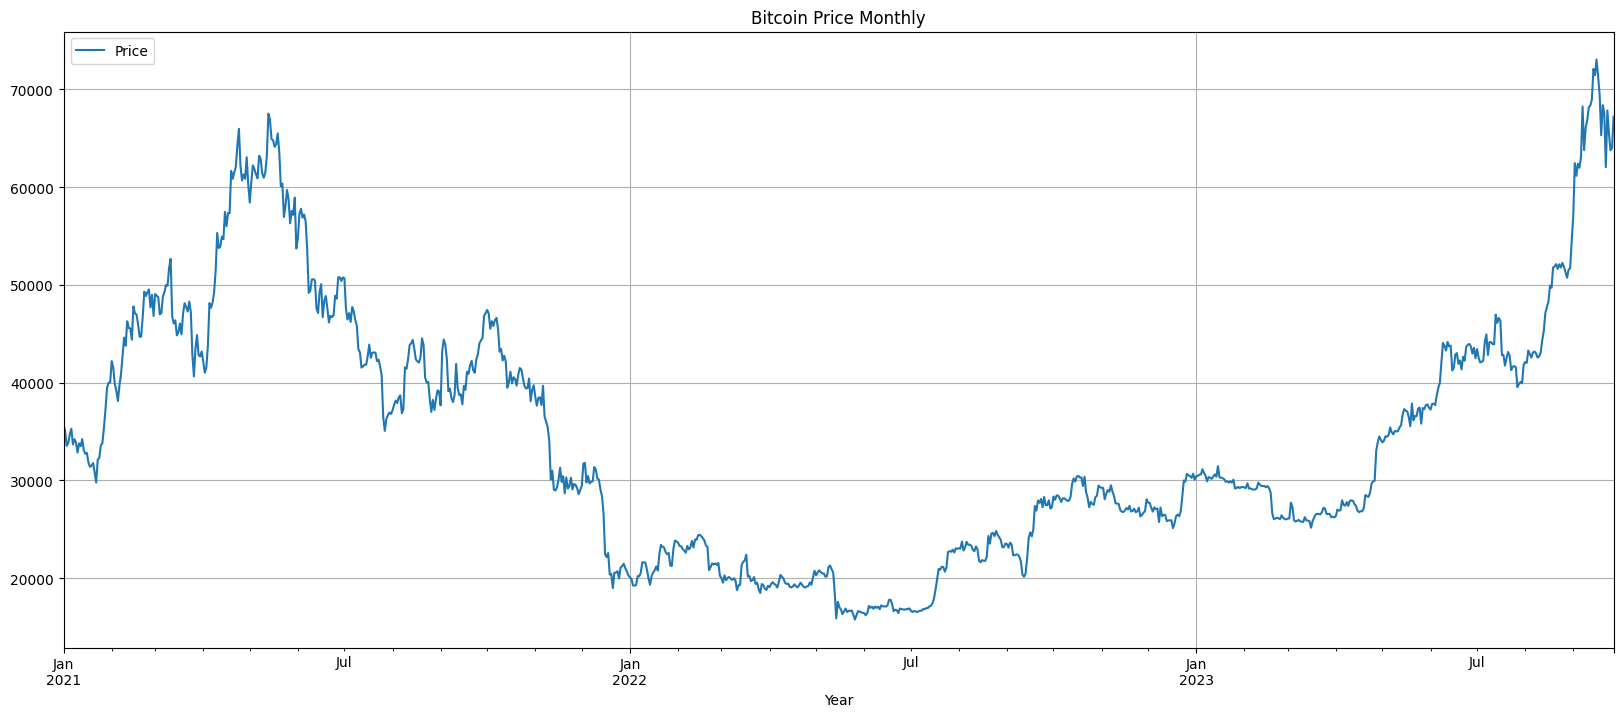

In [ ]:
df.plot(figsize=(20,8))
plt.title("Bitcoin Price Monthly")
plt.grid()

In [ ]:
df.describe()

,Price
count,1000.000000
mean,34278.000300
std,12909.767164
min,15776.200000
25%,23553.925000
50%,30287.700000
75%,42987.550000
max,73066.300000


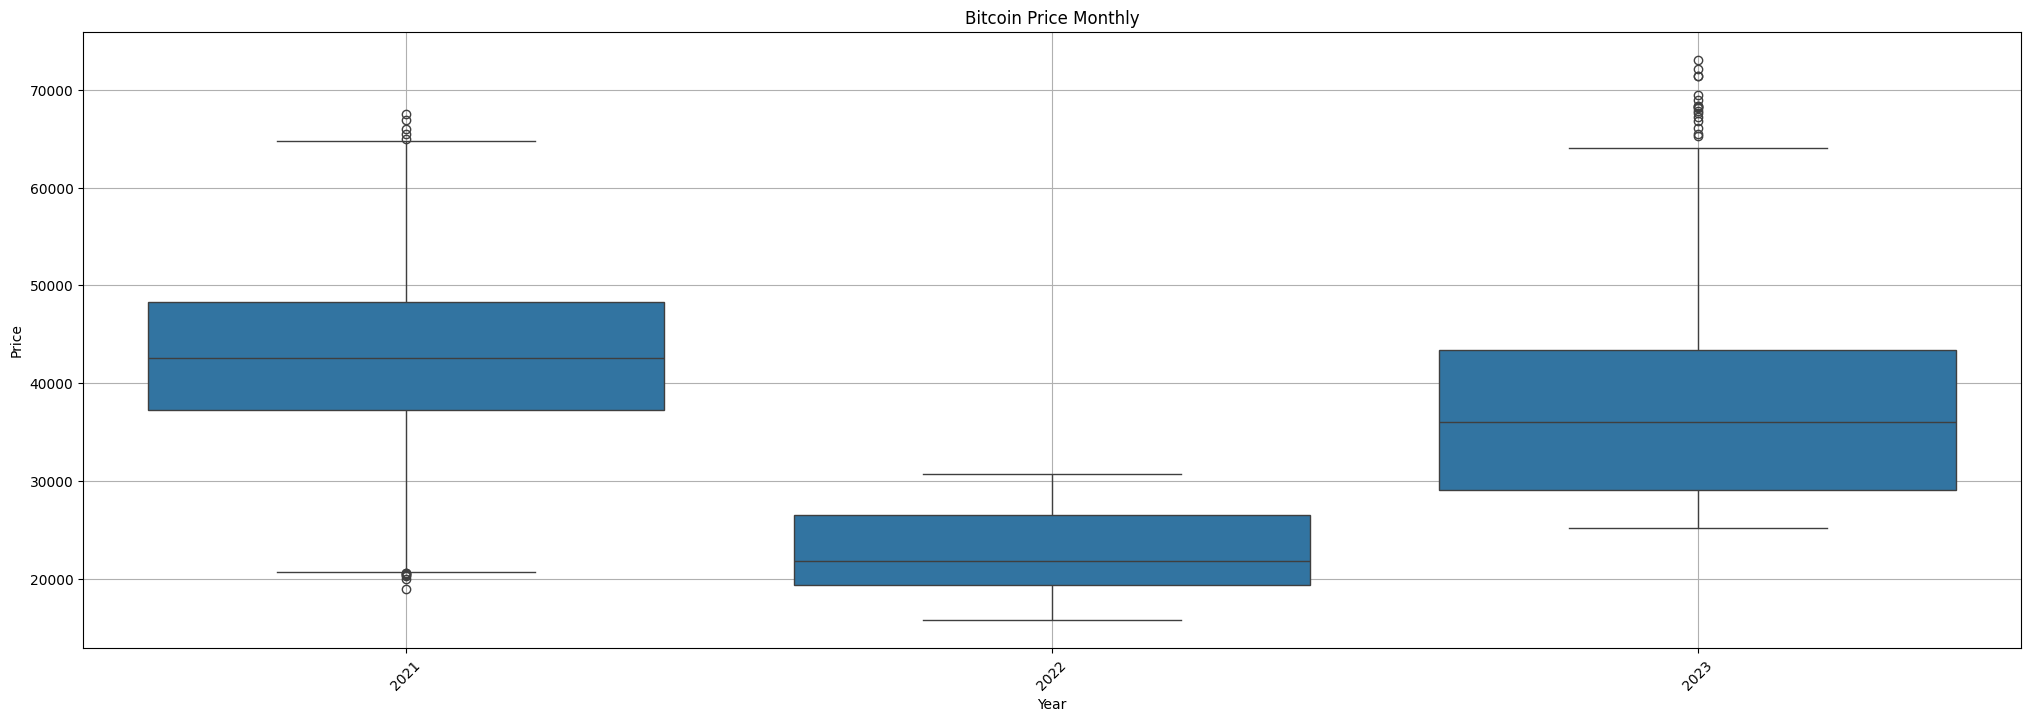

In [ ]:
_ , ax = plt.subplots(figsize=(25,8))
sns.boxplot(x=df.index.year , y=df.values[:,0] , ax=ax)
plt.title("Bitcoin Price Monthly")
plt.xlabel(f"Year")
plt.ylabel(f"Price")
plt.xticks(rotation=45)
plt.grid()

Text(0.5, 1.0, 'Bitcoin Price Monthly')

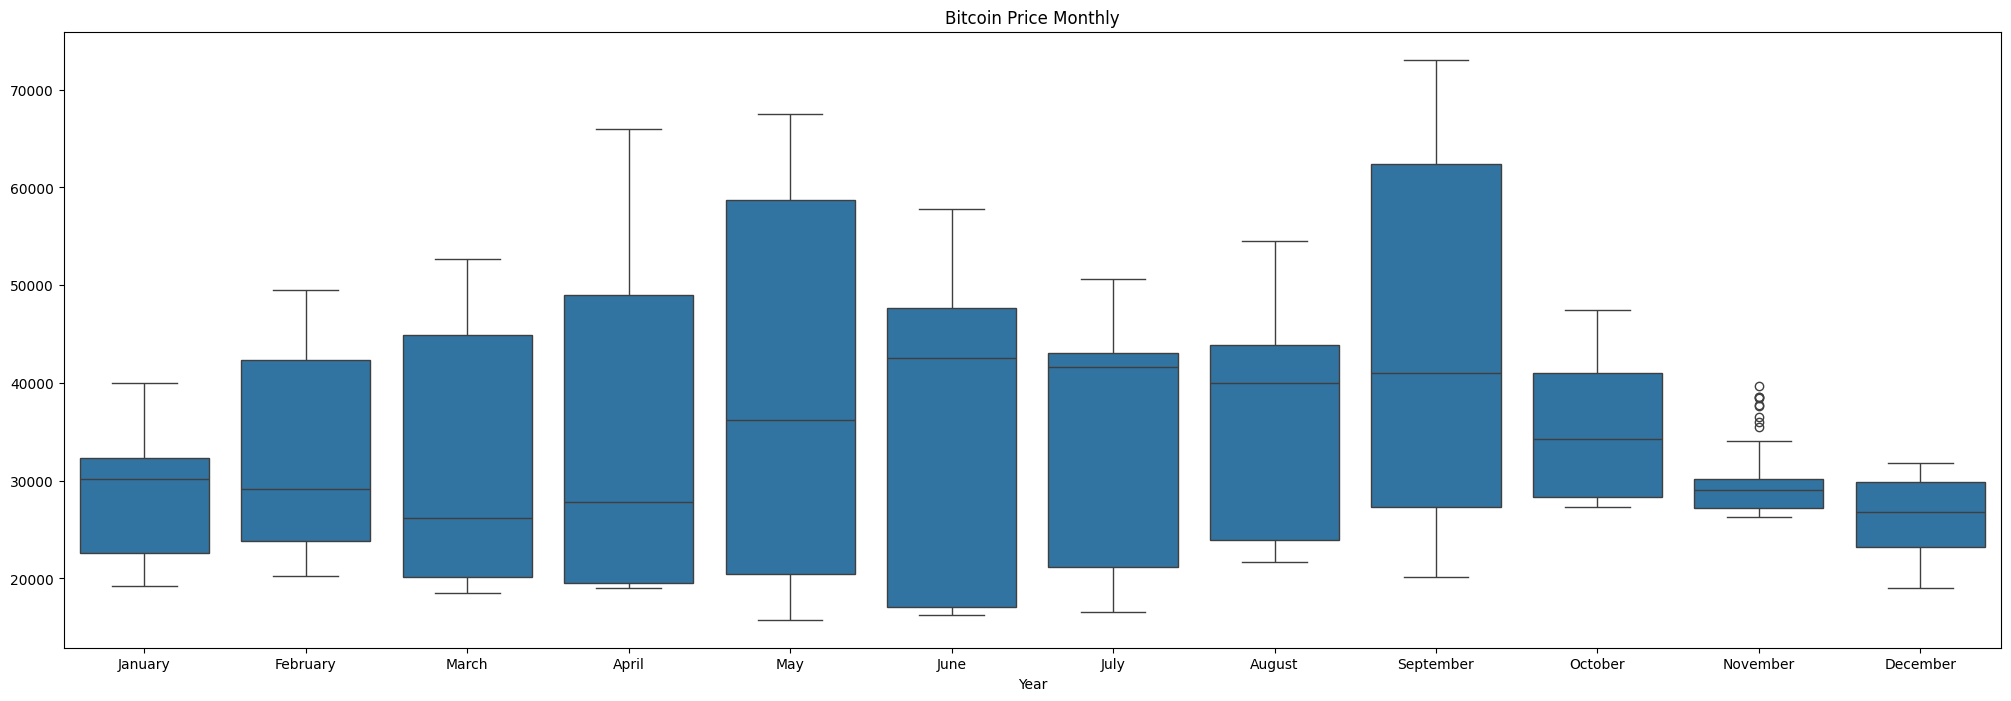

In [ ]:
_ , ax = plt.subplots(figsize=(25,8))
sns.boxplot(x = df.index.month_name() , y = df.values[:,0], ax=ax)
plt.title("Bitcoin Price Monthly")

In [ ]:
df_1 = df.groupby(df.index.year).mean().rename(columns={'Price' : 'Mean'})
df_1 = df_1.merge(df.groupby(df.index.year).std().rename(columns={'Price' : 'Std'}), left_index=True, right_index=True)
df_1['Cov_pct'] = ((df_1['Std']/df_1['Mean'])*100 ).round(2)

In [ ]:
df_1.head()

,Mean,Std,Cov_pct
Year,,,
2021,43032.339178,10251.232577,23.82
2022,22473.435890,4115.530068,18.31
2023,38401.453333,11987.053621,31.22


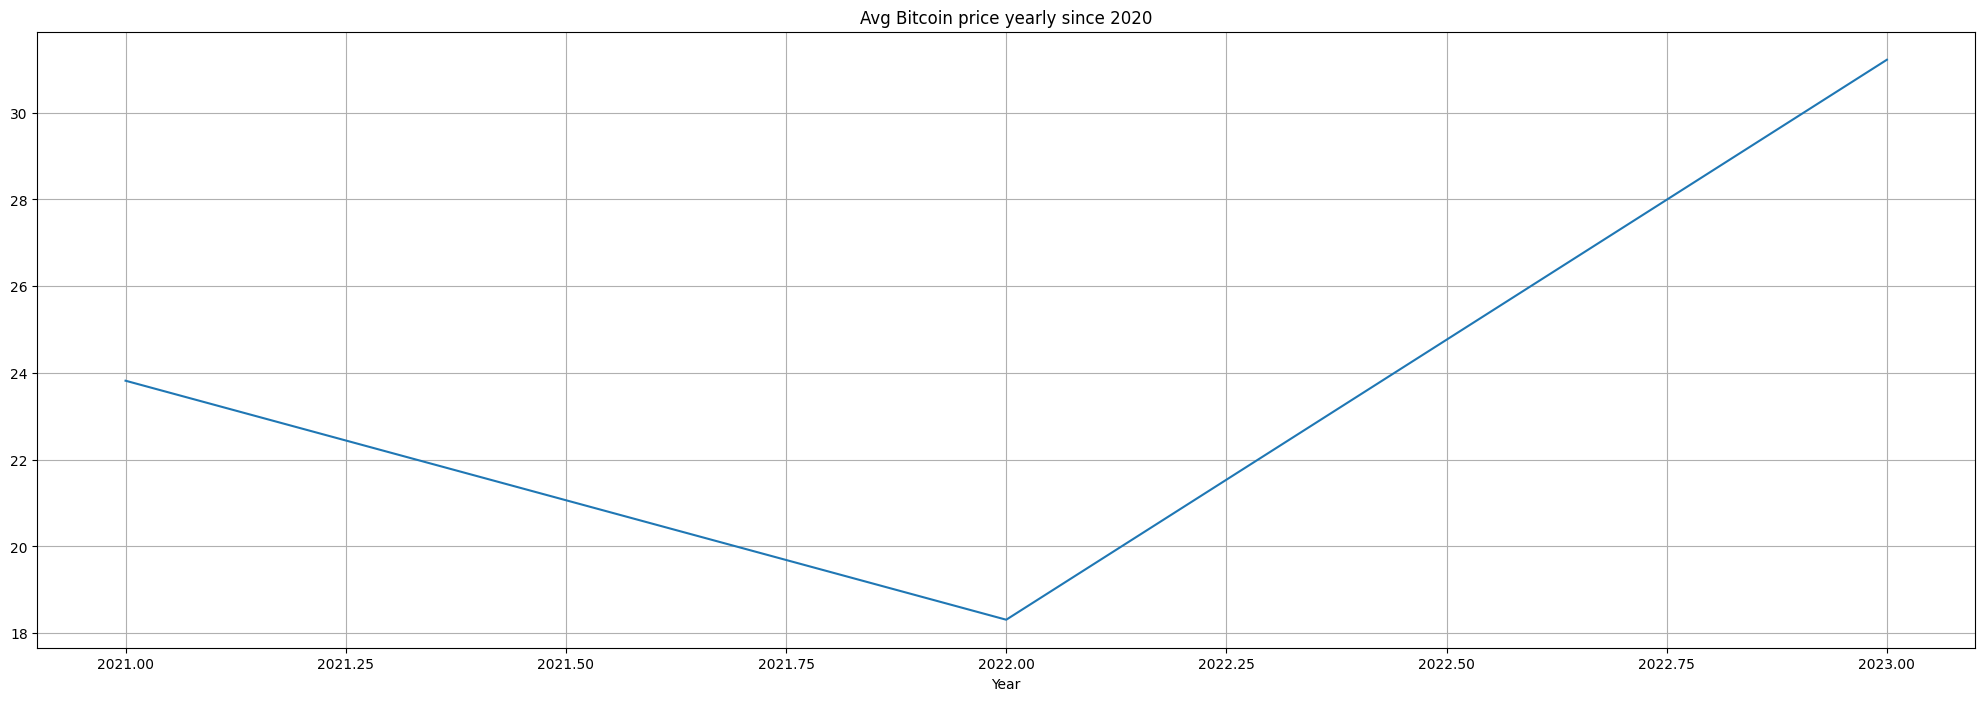

In [ ]:
fig , ax = plt.subplots(figsize=(25,8))
df_1['Cov_pct'].plot()
plt.title("Avg Bitcoin price yearly since 2020")
plt.grid()

In [ ]:
train = df[df.index.year <= 2022]
test = df[df.index.year > 2022]

In [ ]:
print(train.shape)
print(test.shape)

(730, 1)
(270, 1)


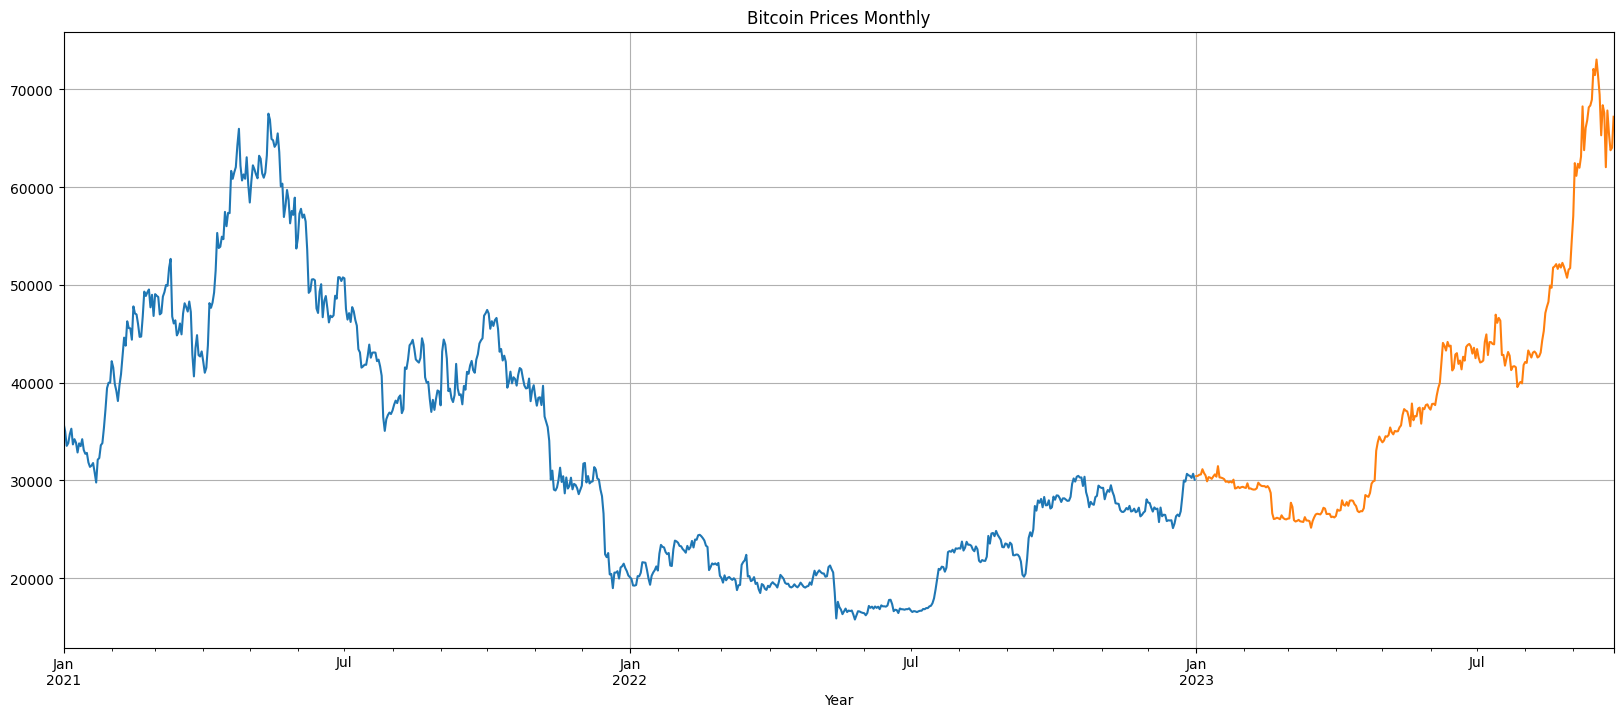

In [ ]:
train['Price'].plot(figsize=(20,8))
test['Price'].plot(figsize=(20,8))
plt.title("Bitcoin Prices Monthly")
plt.grid()

In [ ]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+1 for i in range(len(test))]
len(train_time), len(test_time)

(730, 270)

In [ ]:
Naive_train = train.copy()
Naive_test = test.copy()

In [ ]:
LR_train = train.copy()
LR_test = test.copy()

In [ ]:
Naive_train['time'] = train_time
Naive_test['time'] = test_time

In [ ]:
LR_train['time'] = train_time
LR_test['time'] = test_time

In [ ]:
Naive_test['naive'] = np.asarray(train['Price'])[len(np.asarray(train['Price']))-1]
Naive_test['naive'].head()

,naive
Year,
2023-01-01,30078.6
2023-01-02,30078.6
2023-01-03,30078.6
2023-01-04,30078.6
2023-01-05,30078.6


In [ ]:
lr = LinearRegression()
lr.fit(LR_train[['time']], LR_train['Price'].values)

LinearRegression()

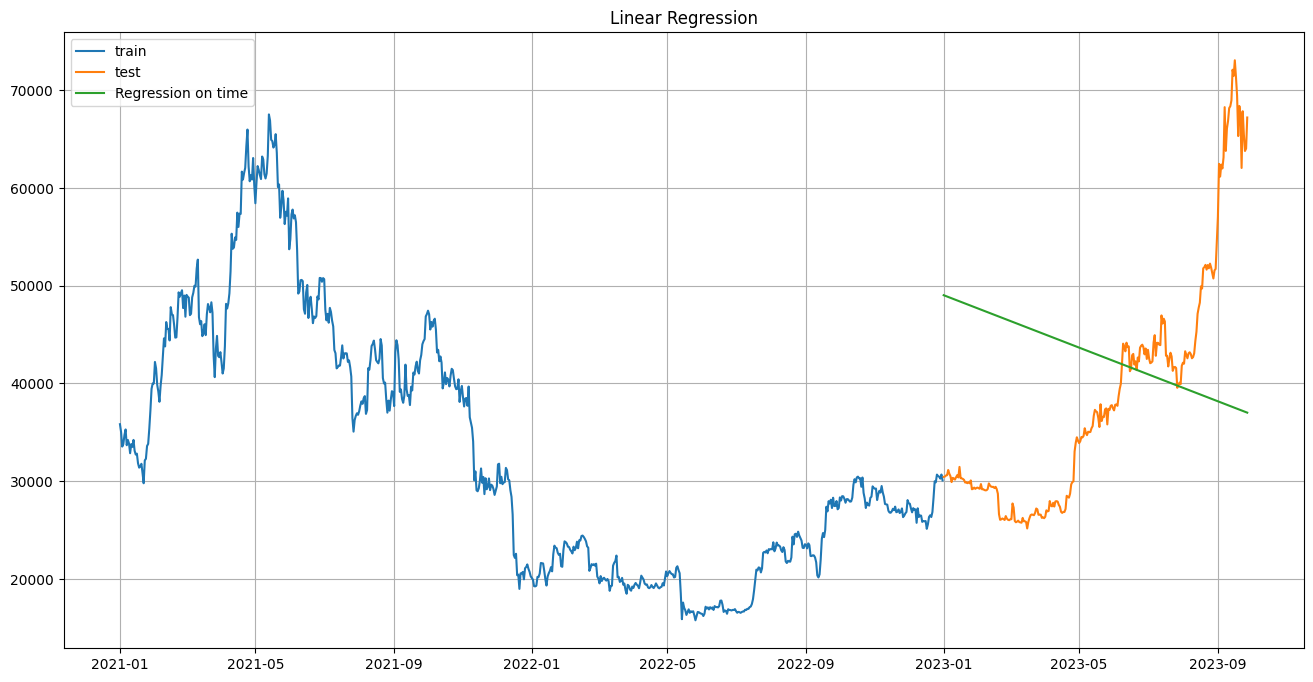

In [ ]:
test_predictions_model = lr.predict(LR_test[['time']])
LR_test['forecast'] = test_predictions_model
plt.figure(figsize=(16,8))
plt.plot(train['Price'],label='train')
plt.plot(test['Price'],label='test')
plt.plot(LR_test['forecast'], label='Regression on time')
plt.title('Linear Regression')
plt.legend(loc='best')
plt.grid()
plt.show()

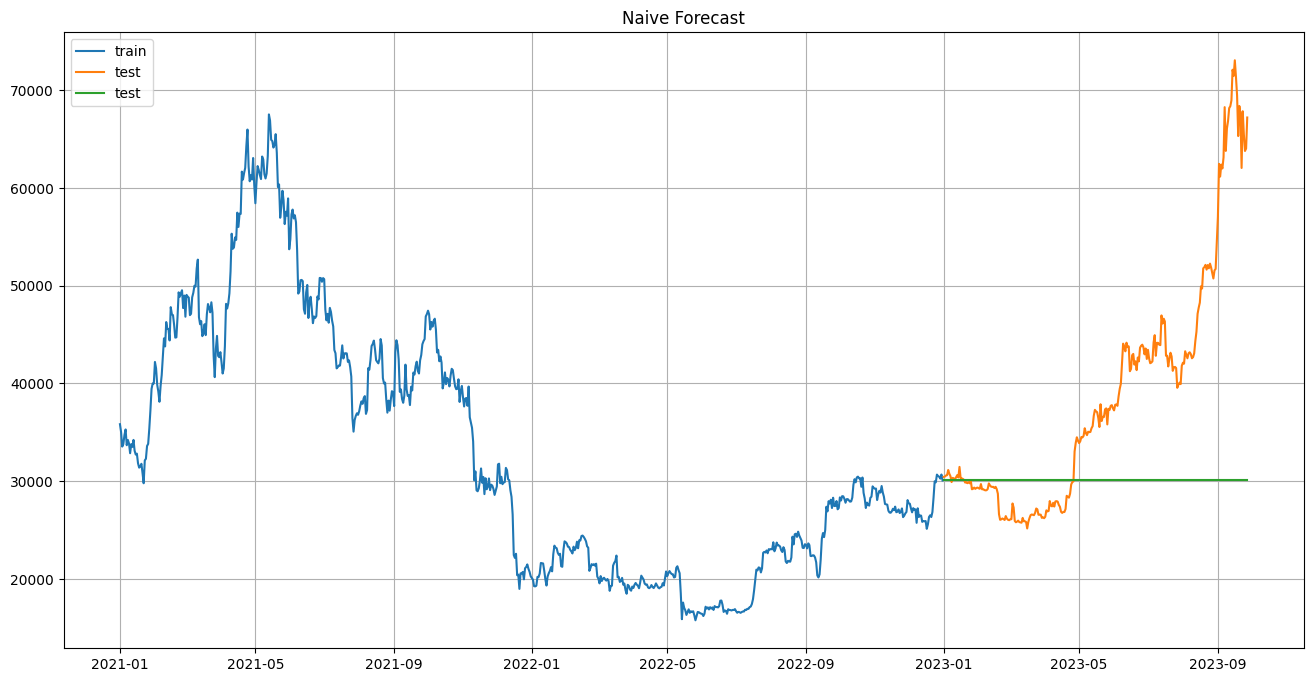

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(Naive_train['Price'],label='train')
plt.plot(test['Price'],label='test')
plt.plot(Naive_test['naive'],label='test')
plt.legend(loc='best')
plt.title('Naive Forecast')
plt.grid()
plt.show()

In [ ]:
def mape(actual,pred):
  return round((np.mean(abs(actual - pred)/actual))*100 , 2)

In [ ]:
mape_model_test = mape(test['Price'].values,test_predictions_model)
print("MAPE is %3.3f"%(mape_model_test),"%")

MAPE is 38.470 %


In [ ]:
results = pd.DataFrame({'Test MAPE (%)': [mape_model_test]}, index=["Regression"])

In [ ]:
results

,Test MAPE (%)
Regression,38.47


In [ ]:
mape_model_test_2 = mape(test['Price'].values,Naive_test['naive'].values)
print("For Naive Forecast on Test data the MAPE is %3.3f"%(mape_model_test_2),"%")

For Naive Forecast on Test data the MAPE is 21.590 %


In [ ]:
results_2 = pd.DataFrame({'Test MAPE (%)': [mape_model_test_2]}, index=["Naive Model"])
result_final = pd.concat( [results,results_2])
result_final

,Test MAPE (%)
Regression,38.47
Naive Model,21.59


In [ ]:
final_model = ExponentialSmoothing(df['Price'],trend='additive',seasonal='additive',seasonal_periods=12).fit(smoothing_level=0.4,smoothing_trend=0.3,smoothing_seasonal=0.6)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
# Ensure the forecasting period doesn't extend too far into the future
forecast_horizon = min(len(test), 30)  # Change 100 to a reasonable number if needed

# Perform the forecast
forecast = final_model.forecast(forecast_horizon)

# Compute the MAPE for the test period, ensuring it matches the forecast horizon
mape_final_model = mape(test['Price'].values[:forecast_horizon], forecast)
print("For Final Model on Test data the MAPE is %3.3f" % mape_final_model, "%")


For Final Model on Test data the MAPE is 46.190 %


In [ ]:
# Limit the forecast horizon to prevent the out-of-bounds error
forecast_horizon = min(len(df), 20)  # Adjust 100 to a smaller number if needed

# Perform the forecast
prediction = final_model.forecast(forecast_horizon)


In [ ]:
pred_df = pd.DataFrame({'lower_CI':prediction - 1.96*np.std(final_model.resid,ddof=1) , 'prediction':prediction , 'upper_CI':prediction + 1.96*np.std(final_model.resid,ddof=1)})

Text(0.5, 1.0, 'Final Model')

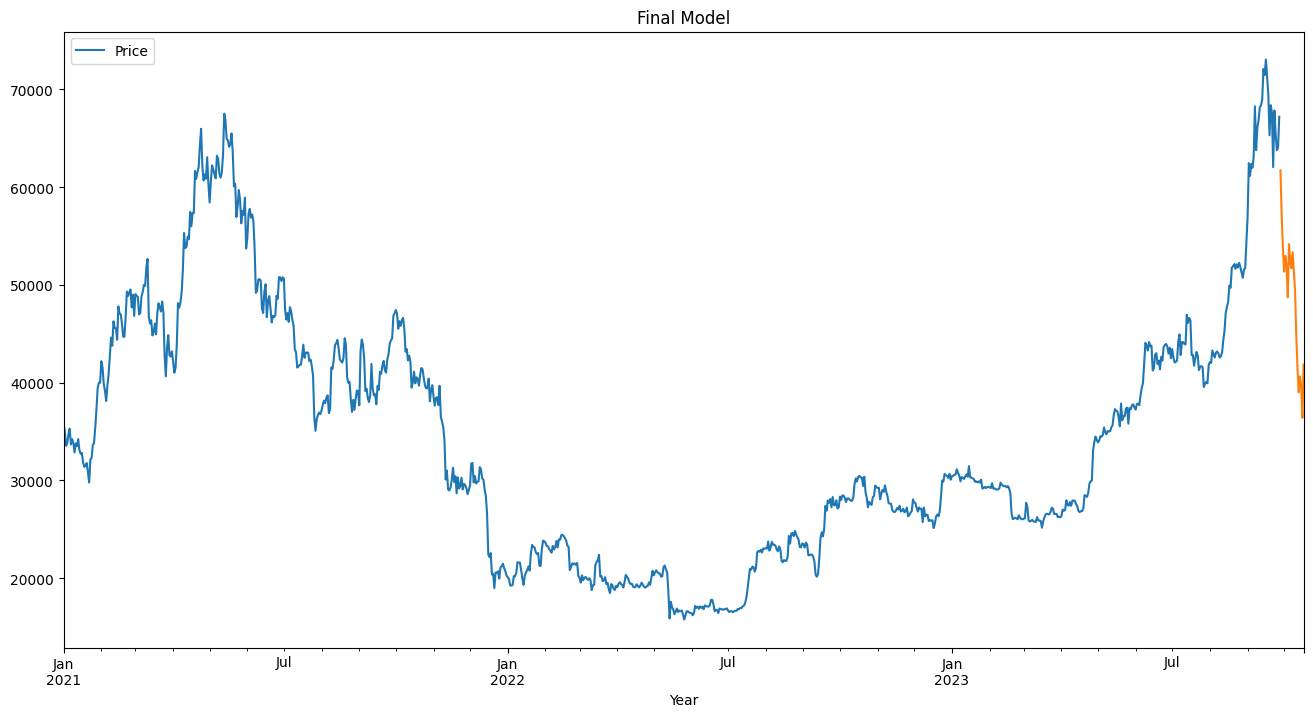

In [ ]:
axis = df.plot(label = 'Actual',figsize=(16,8))
pred_df['prediction'].plot(ax=axis,label='Predicted')
plt.title('Final Model')

In [ ]:
import pickle
from sklearn.linear_model import LinearRegression

# Save the model
with open('bitcoin_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)
print("Model saved successfully as 'linear_regression_model.pkl'.")

# Load the model
with open('linear_regression_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully.")


Model saved successfully as 'linear_regression_model.pkl'.
Model loaded successfully.
